In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import load_model

lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random




Using TensorFlow backend.
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:

words = []
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('merged_json.json').read()
intents = json.loads(data_file)

for intent in intents['intents']:
    for pattern in intent['patterns']:

        # tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])



In [3]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print(len(documents), "documents")
# classes = intents
print(len(classes), "classes", classes)
# words = all words, vocabulary
print(len(words), "unique lemmatized words", words)

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))



99 documents
34 classes ['FUP', 'account', 'afternoon', 'branchoffice', 'cutcable', 'develop', 'evening', 'gameprice', 'gaming', 'hello', 'hi', 'hidessid', 'hosting', 'meaningofonline', 'morning', 'namastae', 'name', 'nettv', 'newconnection', 'offensive', 'okay', 'onlineservicespassword', 'pairremote', 'photoupload', 'portforward', 'renewconnection', 'safenet', 'secondaryrouter', 'services', 'slowconnection', 'thankyou', 'timeback', 'torrent', 'watchnettv']
246 unique lemmatized words [',', '.', 'a', 'able', 'about', 'access', 'account', 'add', 'afternoon', 'also', 'am', 'amount', 'an', 'and', 'any', 'app/application', 'application', 'are', 'back', 'be', 'been', 'bhaster', 'bitch', 'block', 'branch', 'bro', 'browing', 'browsing', 'but', 'by', 'cable', 'can', 'certain', 'change', 'channel', 'claim', 'compensate', 'completely', 'connection', 'contact', 'contain', 'context', 'coorporation', 'could', 'csgo', 'customer', 'cut', 'day', 'declare', 'department', 'detail', 'develop', 'developer

In [4]:

# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:, 0])
train_y = list(training[:, 1])
print("Training data created")



Training data created


In [5]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))




try:
    model = load_model('model.h5')
    print("model load successfully")
except:
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    # fitting and saving the model
    history = model.fit(np.array(train_x), np.array(train_y), epochs=700, batch_size=8, verbose=1)
    model.save('model.h5', history)

    print("model created")


model.summary()





Epoch 1/700
99/99 [==============================] - 0s 2ms/step - loss: 3.5222 - accuracy: 0.0404
Epoch 2/700
99/99 [==============================] - 0s 400us/step - loss: 3.4611 - accuracy: 0.0404
Epoch 3/700
99/99 [==============================] - 0s 389us/step - loss: 3.3689 - accuracy: 0.1111
Epoch 4/700
99/99 [==============================] - 0s 271us/step - loss: 3.3523 - accuracy: 0.1414
Epoch 5/700
99/99 [==============================] - 0s 179us/step - loss: 3.1888 - accuracy: 0.2222
Epoch 6/700
99/99 [==============================] - 0s 180us/step - loss: 3.1702 - accuracy: 0.2020
Epoch 7/700
99/99 [==============================] - 0s 188us/step - loss: 3.1016 - accuracy: 0.2323
Epoch 8/700
99/99 [==============================] - 0s 185us/step - loss: 2.9560 - accuracy: 0.2323
Epoch 9/700
99/99 [==============================] - 0s 173us/step - loss: 2.9116 - accuracy: 0.2323
Epoch 10/700
99/99 [==============================] - 0s 175us/step - loss: 2.7963 - accurac

99/99 [==============================] - 0s 117us/step - loss: 0.3125 - accuracy: 0.9091
Epoch 80/700
99/99 [==============================] - 0s 100us/step - loss: 0.3487 - accuracy: 0.8788
Epoch 81/700
99/99 [==============================] - 0s 113us/step - loss: 0.2979 - accuracy: 0.9192
Epoch 82/700
99/99 [==============================] - 0s 101us/step - loss: 0.4294 - accuracy: 0.8586
Epoch 83/700
99/99 [==============================] - 0s 106us/step - loss: 0.2431 - accuracy: 0.9495
Epoch 84/700
99/99 [==============================] - 0s 104us/step - loss: 0.3647 - accuracy: 0.8586
Epoch 85/700
99/99 [==============================] - 0s 106us/step - loss: 0.3598 - accuracy: 0.9091
Epoch 86/700
99/99 [==============================] - 0s 109us/step - loss: 0.3199 - accuracy: 0.9293
Epoch 87/700
99/99 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 1.00 - 0s 107us/step - loss: 0.3302 - accuracy: 0.9091
Epoch 88/700
99/99 [==============================] -

99/99 [==============================] - 0s 112us/step - loss: 0.1882 - accuracy: 0.9293
Epoch 159/700
99/99 [==============================] - 0s 113us/step - loss: 0.2482 - accuracy: 0.9394
Epoch 160/700
99/99 [==============================] - 0s 112us/step - loss: 0.1505 - accuracy: 0.9596
Epoch 161/700
99/99 [==============================] - 0s 110us/step - loss: 0.1317 - accuracy: 0.9596
Epoch 162/700
99/99 [==============================] - 0s 104us/step - loss: 0.1588 - accuracy: 0.9596
Epoch 163/700
99/99 [==============================] - 0s 118us/step - loss: 0.1340 - accuracy: 0.9596
Epoch 164/700
99/99 [==============================] - 0s 113us/step - loss: 0.1363 - accuracy: 0.9899
Epoch 165/700
99/99 [==============================] - 0s 113us/step - loss: 0.1517 - accuracy: 0.9697
Epoch 166/700
99/99 [==============================] - 0s 102us/step - loss: 0.0964 - accuracy: 0.9899
Epoch 167/700
99/99 [==============================] - 0s 99us/step - loss: 0.0893 - ac

99/99 [==============================] - 0s 108us/step - loss: 0.1419 - accuracy: 0.9495
Epoch 238/700
99/99 [==============================] - 0s 109us/step - loss: 0.1393 - accuracy: 0.9798
Epoch 239/700
99/99 [==============================] - 0s 114us/step - loss: 0.1191 - accuracy: 0.9596
Epoch 240/700
99/99 [==============================] - 0s 110us/step - loss: 0.1452 - accuracy: 0.9596
Epoch 241/700
99/99 [==============================] - 0s 107us/step - loss: 0.1511 - accuracy: 0.9596
Epoch 242/700
99/99 [==============================] - 0s 108us/step - loss: 0.1561 - accuracy: 0.9495
Epoch 243/700
99/99 [==============================] - 0s 113us/step - loss: 0.1219 - accuracy: 0.9596
Epoch 244/700
99/99 [==============================] - 0s 97us/step - loss: 0.1050 - accuracy: 0.9697
Epoch 245/700
99/99 [==============================] - 0s 104us/step - loss: 0.0965 - accuracy: 0.9596
Epoch 246/700
99/99 [==============================] - 0s 108us/step - loss: 0.0607 - ac

99/99 [==============================] - 0s 100us/step - loss: 0.0624 - accuracy: 0.9798
Epoch 317/700
99/99 [==============================] - 0s 100us/step - loss: 0.0456 - accuracy: 1.0000
Epoch 318/700
99/99 [==============================] - 0s 107us/step - loss: 0.1321 - accuracy: 0.9697
Epoch 319/700
99/99 [==============================] - 0s 103us/step - loss: 0.0625 - accuracy: 0.9596
Epoch 320/700
99/99 [==============================] - 0s 100us/step - loss: 0.0846 - accuracy: 0.9697
Epoch 321/700
99/99 [==============================] - 0s 105us/step - loss: 0.1083 - accuracy: 0.9697
Epoch 322/700
99/99 [==============================] - 0s 98us/step - loss: 0.0989 - accuracy: 0.9899
Epoch 323/700
99/99 [==============================] - 0s 104us/step - loss: 0.0503 - accuracy: 0.9899
Epoch 324/700
99/99 [==============================] - 0s 102us/step - loss: 0.0306 - accuracy: 1.0000
Epoch 325/700
99/99 [==============================] - 0s 100us/step - loss: 0.0766 - ac

99/99 [==============================] - 0s 106us/step - loss: 0.0568 - accuracy: 0.9899
Epoch 396/700
99/99 [==============================] - 0s 114us/step - loss: 0.0738 - accuracy: 0.9697
Epoch 397/700
99/99 [==============================] - 0s 105us/step - loss: 0.0336 - accuracy: 0.9899
Epoch 398/700
99/99 [==============================] - 0s 107us/step - loss: 0.0770 - accuracy: 0.9697
Epoch 399/700
99/99 [==============================] - 0s 108us/step - loss: 0.0910 - accuracy: 0.9798
Epoch 400/700
99/99 [==============================] - 0s 107us/step - loss: 0.0480 - accuracy: 0.9899
Epoch 401/700
99/99 [==============================] - 0s 101us/step - loss: 0.0275 - accuracy: 1.0000
Epoch 402/700
99/99 [==============================] - 0s 117us/step - loss: 0.0420 - accuracy: 0.9798
Epoch 403/700
99/99 [==============================] - 0s 116us/step - loss: 0.0902 - accuracy: 0.9697
Epoch 404/700
99/99 [==============================] - 0s 96us/step - loss: 0.0980 - ac

99/99 [==============================] - 0s 116us/step - loss: 0.0433 - accuracy: 0.9899
Epoch 475/700
99/99 [==============================] - 0s 106us/step - loss: 0.1460 - accuracy: 0.9394
Epoch 476/700
99/99 [==============================] - 0s 115us/step - loss: 0.0660 - accuracy: 0.9899
Epoch 477/700
99/99 [==============================] - 0s 105us/step - loss: 0.0228 - accuracy: 1.0000
Epoch 478/700
99/99 [==============================] - 0s 108us/step - loss: 0.0543 - accuracy: 0.9899
Epoch 479/700
99/99 [==============================] - 0s 102us/step - loss: 0.1435 - accuracy: 0.9394
Epoch 480/700
99/99 [==============================] - 0s 106us/step - loss: 0.0503 - accuracy: 0.9798
Epoch 481/700
99/99 [==============================] - 0s 101us/step - loss: 0.0711 - accuracy: 0.9798
Epoch 482/700
99/99 [==============================] - 0s 104us/step - loss: 0.0221 - accuracy: 1.0000
Epoch 483/700
99/99 [==============================] - 0s 103us/step - loss: 0.0216 - a

99/99 [==============================] - 0s 113us/step - loss: 0.0335 - accuracy: 1.0000
Epoch 554/700
99/99 [==============================] - 0s 134us/step - loss: 0.0707 - accuracy: 0.9798
Epoch 555/700
99/99 [==============================] - 0s 117us/step - loss: 0.0733 - accuracy: 0.9798
Epoch 556/700
99/99 [==============================] - 0s 112us/step - loss: 0.0434 - accuracy: 0.9899
Epoch 557/700
99/99 [==============================] - 0s 108us/step - loss: 0.1056 - accuracy: 0.9697
Epoch 558/700
99/99 [==============================] - 0s 106us/step - loss: 0.0816 - accuracy: 0.9798
Epoch 559/700
99/99 [==============================] - 0s 102us/step - loss: 0.0337 - accuracy: 1.0000
Epoch 560/700
99/99 [==============================] - 0s 110us/step - loss: 0.0560 - accuracy: 0.9798
Epoch 561/700
99/99 [==============================] - 0s 105us/step - loss: 0.0293 - accuracy: 0.9899
Epoch 562/700
99/99 [==============================] - 0s 104us/step - loss: 0.0283 - a

99/99 [==============================] - 0s 106us/step - loss: 0.0772 - accuracy: 0.9798
Epoch 633/700
99/99 [==============================] - 0s 99us/step - loss: 0.0327 - accuracy: 0.9899
Epoch 634/700
99/99 [==============================] - 0s 102us/step - loss: 0.0359 - accuracy: 0.9899
Epoch 635/700
99/99 [==============================] - 0s 112us/step - loss: 0.0554 - accuracy: 0.9899
Epoch 636/700
99/99 [==============================] - 0s 101us/step - loss: 0.0919 - accuracy: 0.9596
Epoch 637/700
99/99 [==============================] - 0s 99us/step - loss: 0.0670 - accuracy: 0.9697
Epoch 638/700
99/99 [==============================] - 0s 109us/step - loss: 0.0701 - accuracy: 0.9899
Epoch 639/700
99/99 [==============================] - 0s 102us/step - loss: 0.0244 - accuracy: 1.0000
Epoch 640/700
99/99 [==============================] - 0s 103us/step - loss: 0.1871 - accuracy: 0.9495
Epoch 641/700
99/99 [==============================] - 0s 106us/step - loss: 0.0408 - acc

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


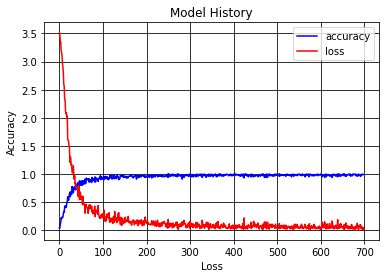

In [7]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['loss'],color='red',label='loss')

plt.title('Model History')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.grid(True,color='k')
plt.legend(['accuracy', 'loss'])
plt.show()